<a href="https://colab.research.google.com/github/iljeong/Final-Team10/blob/main/10%ED%8C%80_%EC%84%9C%EC%A0%95%EC%9D%BC_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 가설: 사용자의 활동 패턴(활동 기간, 장르 다양성, 태그 참여도 등)에 따라 영화 선호도가 다를 것이다.

##변수명

1. 원본 데이터셋 변수

- userId : 사용자 ID

- movieId : 영화 ID

- rating : 평점 (0.5~5.0)

- timestamp : 평점 시각

- title : 영화 제목

- genres : 영화 장르

2. 가공된 변수

| 변수명                           | 만든 원본 변수                         | 의미 / 계산 방법                                                 |
| ----------------------------- | -------------------------------- | ---------------------------------------------------------- |
| `rating_dt`                   | `timestamp`                      | 평점 시각을 datetime(UTC)으로 변환                                  |
| `rating_year`                 | `timestamp`                      | `rating_dt`에서 연도 추출                                        |
| `release_year`                | `title`                          | 제목 내 괄호 연도(예: `(1995)`) 추출                                 |
| `content_age_years`           | `rating_year`, `release_year`    | 평가 연도 − 개봉 연도 (작을수록 신작 지향)                                 |
| `rating_mean`                 | `rating`                         | 사용자별 평균 평점                                                 |
| `rating_std`                  | `rating`                         | 사용자별 평점 표준편차 *(필터 후 2개 미만 평점이면 NaN 가능)*                    |
| `mainstream_ratio`            | `movieId`, `rating`              | **현재 분석 df의** 영화별 평점 수 분포에서 상위 10% 인기작을 본 비율               |
| `recency_mean`                | `content_age_years`              | `-content_age_years`의 사용자별 평균 (값↑ = 신작 선호)                 |
| `fresh_mean`                  | `content_age_years`              | 사용자별 평균 콘텐츠 연령 *(legacy 명칭, 값↓ = 신작 선호)*                   |
| `rarity_median_idf`           | `movieId`, `userId`              | \*\*idf=log(n\_users / (df\_m + 1))\*\*의 사용자별 중앙값 (희소작 선호) |
| `early_age`                   | `timestamp`, `content_age_years` | 각 유저 **초기 20% 평점**에서의 평균 `content_age_years`               |
| `recent_age`                  | `timestamp`, `content_age_years` | 각 유저 **최근 20% 평점**에서의 평균 `content_age_years`               |
| `early_group`, `recent_group` | `early_age`, `recent_age`        | **전체 데이터의** `content_age_years` 중앙값 기준으로 신작/복고 라벨링         |

3. 세그먼트 변수

| 세그먼트명                                          | 만든 원본 변수                      | 설명                                     |
| ---------------------------------------------- | ----------------------------- | -------------------------------------- |
| **활동 기간 (`tenure_days`, `activity_quartile`)** | `timestamp`                   | 최초\~최종 평점 간 일수, 4분위(Q1\~Q4) 분류         |
| **장르 다양성 (`uniq_genres`, `genre_quartile`)**   | `genres`, `movieId`, `userId` | 사용자가 본 **고유 장르 수** 기준으로 4분위(Q1\~Q4) 분류 |
| **태그 참여도 (`tag_active`)**                      | *(tags.csv의)* `userId`        | 태그 **작성 여부**만 사용(텍스트 내용은 미사용): 참여/비참여  |

In [20]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# 통계/시각화
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# 0) 설정값(한 곳에서 바꾸면 전체 반영)
CONFIG = {
    "PATHS": {
        "ratings":  "/content/drive/MyDrive/파이널 프로젝트/전처리 파일/ML_ratings_df.csv",
        "movies":   "/content/drive/MyDrive/파이널 프로젝트/전처리 파일/ML_movies_df.csv",
        "tags":     "/content/drive/MyDrive/파이널 프로젝트/전처리 파일/ML_tags_df.csv",
        "links":    "/content/drive/MyDrive/파이널 프로젝트/전처리 파일/ML_links_df.csv",  # 선택(있으면 읽힘)
    },
    # 분석 매개변수
    "USE_SINCE_YEAR": None,      # 예: 2020 (None이면 전체)
    "MAINSTREAM_TOP_PCT": 0.10,  # 상위 10%를 인기작으로 정의
    "MIN_RATINGS_PER_GROUP": 30, # 영화 단위 Welch t-test 최소 표본 수
    "TOP_K_MOVIES": 15,          # 효과큰 영화 상위 몇 개 출력
    "SAVE_DIR": "/mnt/data",     # 결과 저장 폴더(None이면 저장 X)
}

In [21]:
# 1) 용어 사전(라벨/칼럼/키워드)
VOCAB = {
    "NEW_KO": "신작성향",
    "RETRO_KO": "복고성향",
    "NEW_EN": "recent_pref",
    "RETRO_EN": "retro_pref",

    "TENURE_Q_LABELS": ["Q1(최단)","Q2","Q3","Q4(최장)"],
    "GENRE_Q_LABELS":  ["Q1(좁음)","Q2","Q3","Q4(다양)"],

    "COLS": {
        "user_id": "userId",
        "movie_id": "movieId",
        "rating": "rating",
        "timestamp": "timestamp",
        "title": "title",
        "genres": "genres",
        "rating_dt": "rating_dt",
        "rating_year": "rating_year",
        "release_year": "release_year",
        "content_age": "content_age_years",
        "rating_mean": "rating_mean",
        "rating_std": "rating_std",
        "mainstream_ratio": "mainstream_ratio",
        "rarity_median_idf": "rarity_median_idf",
        "recency_mean": "recency_mean",            # == -content_age 평균
        "fresh_mean_legacy": "fresh_mean",         # 호환용
        "activity_quartile": "activity_quartile",
        "genre_quartile": "genre_quartile",
        "tenure_days": "tenure_days",
        "uniq_genres": "uniq_genres",
        "tag_active_flag": "tag_active",
    }
}

In [22]:
# 2) 한글 폰트 자동 적용
def apply_korean_font():
    candidates = ["AppleGothic", "Malgun Gothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    chosen = next((f for f in candidates if f in installed), None)
    if chosen:
        mpl.rcParams["font.family"] = chosen
    mpl.rcParams["axes.unicode_minus"] = False
apply_korean_font()

In [23]:
# 3) 공통 유틸
C = VOCAB["COLS"]

def _clean_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()

def cohens_d(a, b):
    a, b = _clean_numeric(a), _clean_numeric(b)
    na, nb = len(a), len(b)
    if na < 2 or nb < 2: return np.nan
    pooled = np.sqrt(((na-1)*a.var(ddof=1) + (nb-1)*b.var(ddof=1)) / (na+nb-2))
    return 0.0 if pooled == 0 else (a.mean() - b.mean()) / pooled

def eta_squared_anova(groups, all_values):
    gm = np.mean(all_values)
    ss_between = sum([len(g)*((np.mean(g) - gm)**2) for g in groups])
    ss_total = np.sum((all_values - gm)**2)
    return np.nan if ss_total == 0 else ss_between/ss_total

def maybe_save(df, name):
    sd = CONFIG["SAVE_DIR"]
    if sd:
        os.makedirs(sd, exist_ok=True)
        path = os.path.join(sd, name)
        df.to_csv(path, index=False)
        print(f"[저장] {path}")

def q4_by_rank(s: pd.Series, labels):
    s = pd.to_numeric(s, errors="coerce")
    r = s.rank(method="first")
    return pd.qcut(r, 4, labels=labels)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# 4) 데이터 로딩(단일 경로 사용)
paths = CONFIG["PATHS"]
ML_ratings_df = pd.read_csv(paths["ratings"])
ML_movies_df  = pd.read_csv(paths["movies"])
ML_tags_df    = pd.read_csv(paths["tags"])

try:
    ML_links_df = pd.read_csv(paths["links"])
except Exception:
    ML_links_df = pd.DataFrame()

In [32]:
# 5) 피처 엔지니어링(표준 변수명으로 생성)

# (a) 개봉연도
movies = ML_movies_df.copy()
year_from_paren = movies[C["title"]].str.extract(r"\((\d{4})\)\s*$", expand=False)
year_anywhere   = movies[C["title"]].str.extract(r"(\d{4})", expand=False)
movies[C["release_year"]] = pd.to_numeric(year_from_paren.fillna(year_anywhere), errors="coerce")

# (b) 평점 시점
ratings = ML_ratings_df.copy()
ratings[C["rating_dt"]]   = pd.to_datetime(ratings[C["timestamp"]], unit="s", utc=True)
ratings[C["rating_year"]] = ratings[C["rating_dt"]].dt.year.astype("Int64")

# (c) 병합 및 콘텐츠 연령
df = ratings.merge(movies[[C["movie_id"], C["release_year"]]], on=C["movie_id"], how="left")
df[C["content_age"]] = df[C["rating_year"]].astype(float) - df[C["release_year"]].astype(float)

# (선택) 특정 연도 이후만
if CONFIG["USE_SINCE_YEAR"] is not None:
    df = df[df[C["rating_year"]] >= CONFIG["USE_SINCE_YEAR"]].copy()

# (d) 유저 단위 요약
rating_mean = df.groupby(C["user_id"])[C["rating"]].mean().rename(C["rating_mean"])
rating_std  = df.groupby(C["user_id"])[C["rating"]].std().rename(C["rating_std"])

# (e) 메인스트림(인기작) 비율
movie_rate_cnt = df.groupby(C["movie_id"]).size().rename("movie_rate_count")
movie_rate_pct_rank = movie_rate_cnt.rank(pct=True, method="max")
popular_movies = movie_rate_pct_rank[movie_rate_pct_rank >= (1 - CONFIG["MAINSTREAM_TOP_PCT"])].index
df["__is_mainstream"] = df[C["movie_id"]].isin(popular_movies).astype(int)
mainstream_ratio = df.groupby(C["user_id"])["__is_mainstream"].mean().rename(C["mainstream_ratio"])

# (f) 신작/복고 성향(콘텐츠 연령 기반)
valid_age = df.dropna(subset=[C["content_age"]]).copy()
recency_mean = (-valid_age.groupby(C["user_id"])[C["content_age"]].mean()).rename(C["recency_mean"])
fresh_mean_legacy = valid_age.groupby(C["user_id"])[C["content_age"]].mean().rename(VOCAB["COLS"]["fresh_mean_legacy"])

# (g) 희소성(IDF)
n_users = df[C["user_id"]].nunique()
df_m = df.groupby(C["movie_id"])[C["user_id"]].nunique().rename("df_m")
idf_m = np.log(n_users / (df_m + 1))
idf_m.name = "idf_m"
df = df.merge(idf_m.to_frame(), on=C["movie_id"], how="left")
rarity_median_idf = df.groupby(C["user_id"])["idf_m"].median().rename(C["rarity_median_idf"])

# 최종 유저 피처
ML_user_features_df = (
    pd.concat([rating_mean, rating_std, mainstream_ratio, recency_mean, fresh_mean_legacy, rarity_median_idf], axis=1)
      .reset_index()
      .rename(columns={ "index": C["user_id"] })
      .sort_values(C["user_id"])
)

print("[preview] ML_user_features_df")
print(ML_user_features_df.head(5))


[preview] ML_user_features_df
   userId  rating_mean  rating_std  mainstream_ratio  recency_mean  \
0      22     3.736364    0.738207          0.981818    -16.648148   
1      23     4.651515    0.384969          0.969697     -6.878788   
2      25     3.327586    0.559420          0.988506    -27.333333   
3      26     4.469697    0.648790          1.000000    -20.666667   
4      28     3.929530    0.794874          0.932886     -6.800000   

   fresh_mean  rarity_median_idf  
0   16.648148           2.657422  
1    6.878788           2.900441  
2   27.333333           2.603048  
3   20.666667           1.375247  
4    6.800000           3.356417  


In [33]:
# --- ✅ 2020+ 일관성 안전장치 (피처 엔지니어링 직후 추가) ---
YEAR_CUTOFF = 2020

# ratings 쪽(이미 필터되어 있다면 통과)
assert pd.to_datetime(ML_ratings_df["timestamp"], unit="s", utc=True).dt.year.min() >= YEAR_CUTOFF, \
    f"ML_ratings_df 안에 {YEAR_CUTOFF} 이전 데이터가 섞여 있어요!"

# df(병합/파생 후 테이블)도 재확인 & 필요 시 강제 필터
min_year_df = pd.to_datetime(ratings[C["timestamp"]], unit="s", utc=True).dt.year.min()
if min_year_df < YEAR_CUTOFF:
    df = df[df[C["rating_year"]] >= YEAR_CUTOFF].copy()

# tags도 동일 기준으로 정렬(태그는 보통 별도로 필터 안 되어 있으니 맞춰주는 게 안전)
tags = ML_tags_df.copy()
tags_dt = pd.to_datetime(tags[C["timestamp"]], unit="s", utc=True)
tags = tags.loc[tags_dt.dt.year >= YEAR_CUTOFF].copy()

# 이후 태그 참여 파트에서 tag_user는 'tags' 사용
tag_user = tags.groupby(C["user_id"]).size().rename("tag_count").reset_index()

In [34]:
# 6) 태그 참여 플래그 & 초기/최근 성향
# 태그 참여(1회 이상)
tag_user = ML_tags_df.groupby(C["user_id"]).size().rename("tag_count").reset_index()
user_flag = ML_user_features_df[[C["user_id"], VOCAB["COLS"]["fresh_mean_legacy"]]].merge(tag_user, on=C["user_id"], how="left").fillna({"tag_count":0})
user_flag[VOCAB["COLS"]["tag_active_flag"]] = np.where(user_flag["tag_count"]>0, "참여", "비참여")

# 초기/최근: 각 유저 평가의 앞/뒤 20% 평균 content_age
def early_recent_age(grp):
    grp = grp.sort_values(C["rating_dt"])
    n = len(grp); k = max(1, n//5)
    return pd.Series({
        "early_age":  grp.head(k)[C["content_age"]].mean(),
        "recent_age": grp.tail(k)[C["content_age"]].mean()
    })
user_time = df.groupby(C["user_id"]).apply(early_recent_age).reset_index()

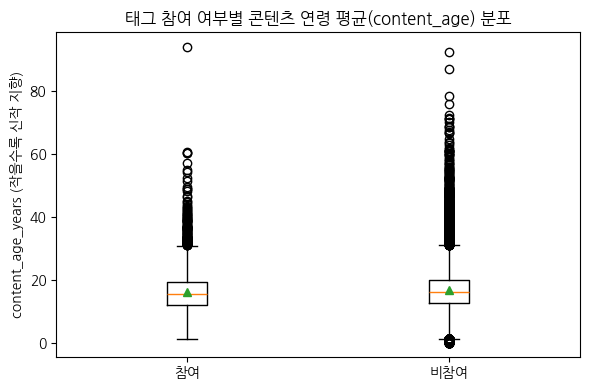

[태그 참여 vs 비참여] Welch t=-3.805, p=0.000143, d=-0.065 | mean(age): 참여=16.166, 비참여=16.629 | n=(3796, 25548)


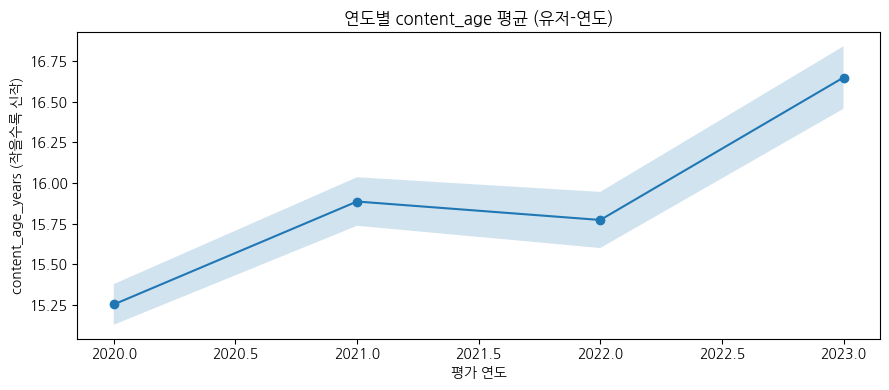

[Kruskal by rating_year] H=166.394, p=7.639e-36, η²≈0.003
[전반(≤2021) vs 후반(>2021)] U=237702686.0, p=1.665e-16, d=-0.077 | means: 전반=15.541, 후반=16.187
[추세 OLS] 연도계수=0.403161, p=5.328e-29, R²=0.003


In [35]:
# 7) 기본 시각화 & 검정
# ----------------------------
# (a) 태그 참여별 content_age 평균 차이 (Welch t)
data_active  = _clean_numeric(user_flag.loc[user_flag[VOCAB["COLS"]["tag_active_flag"]]=="참여", VOCAB["COLS"]["fresh_mean_legacy"]])
data_passive = _clean_numeric(user_flag.loc[user_flag[VOCAB["COLS"]["tag_active_flag"]]=="비참여", VOCAB["COLS"]["fresh_mean_legacy"]])

plt.figure(figsize=(6,4))
plt.boxplot([data_active, data_passive], labels=["참여","비참여"], showmeans=True)
plt.title("태그 참여 여부별 콘텐츠 연령 평균(content_age) 분포")
plt.ylabel("content_age_years (작을수록 신작 지향)")
plt.tight_layout(); plt.show()

t1, p1 = stats.ttest_ind(data_active, data_passive, equal_var=False)
d1 = cohens_d(data_active, data_passive)
print(f"[태그 참여 vs 비참여] Welch t={t1:.3f}, p={p1:.6f}, d={d1:.3f} | "
      f"mean(age): 참여={data_active.mean():.3f}, 비참여={data_passive.mean():.3f} | "
      f"n=({len(data_active)}, {len(data_passive)})")

# (b) 연도별 흐름(유저-연도 평균 content_age)
user_year = df.groupby([C["user_id"], C["rating_year"]])[C["content_age"]].mean().reset_index(name="content_age_mean_yearly")
summary = user_year.groupby(C["rating_year"])["content_age_mean_yearly"].agg(['mean','count','std']).reset_index()
summary["se"] = summary["std"]/np.sqrt(summary["count"].replace(0,np.nan))
summary["ci_low"]  = summary["mean"] - 1.96*summary["se"]
summary["ci_high"] = summary["mean"] + 1.96*summary["se"]

plt.figure(figsize=(9,4))
plt.plot(summary[C["rating_year"]], summary["mean"], marker="o")
plt.fill_between(summary[C["rating_year"]], summary["ci_low"], summary["ci_high"], alpha=0.2)
plt.title("연도별 content_age 평균 (유저-연도)")
plt.xlabel("평가 연도"); plt.ylabel("content_age_years (작을수록 신작)")
plt.tight_layout(); plt.show()

# Kruskal
def to_decade(y):
    if y < 2000: return "1990년대 이전"
    elif y < 2010: return "2000년대"
    elif y < 2020: return "2010년대"
    else:         return "2020년대"

user_year["era_decade"] = user_year[C["rating_year"]].apply(to_decade)
era_col = "era_decade" if user_year["era_decade"].nunique() >= 2 else C["rating_year"]
groups = [_clean_numeric(g["content_age_mean_yearly"]) for _, g in user_year.groupby(era_col)]
groups = [g for g in groups if len(g)>0]
if len(groups) >= 2:
    kw_stat, kw_p = stats.kruskal(*groups)
    eta2_kw = eta_squared_anova(groups, _clean_numeric(user_year["content_age_mean_yearly"]).values)
    print(f"[Kruskal by {era_col}] H={kw_stat:.3f}, p={kw_p:.3e}, η²≈{eta2_kw:.3f}")

median_year = int(user_year[C["rating_year"]].median())
early_bin = _clean_numeric(user_year.loc[user_year[C["rating_year"]] <= median_year, "content_age_mean_yearly"])
late_bin  = _clean_numeric(user_year.loc[user_year[C["rating_year"]] >  median_year, "content_age_mean_yearly"])
if len(early_bin) > 0 and len(late_bin) > 0:
    u_stat, u_p = stats.mannwhitneyu(early_bin, late_bin, alternative="two-sided")
    d_bin = cohens_d(early_bin, late_bin)
    print(f"[전반(≤{median_year}) vs 후반(>{median_year})] U={u_stat:.1f}, p={u_p:.3e}, d={d_bin:.3f} | "
          f"means: 전반={early_bin.mean():.3f}, 후반={late_bin.mean():.3f}")

m_trend = smf.ols("content_age_mean_yearly ~ rating_year", data=user_year.rename(columns={C["rating_year"]:"rating_year"})).fit(cov_type="HC3")
print(f"[추세 OLS] 연도계수={m_trend.params.get('rating_year',np.nan):.6f}, "
      f"p={m_trend.pvalues.get('rating_year',np.nan):.3e}, R²={m_trend.rsquared:.3f}")


[영화별 유의 리스트(FDR 보정) — 상위]
 movieId                                   title          t            p    p_adj_fdr         d  n_retro  n_new  mean_retro  mean_new
  122914 Avengers: Infinity War - Part II (2019) -20.324441 6.625594e-89 3.198837e-85 -0.473345     3345   5045    3.561883  4.068186
  122912  Avengers: Infinity War - Part I (2018) -20.245680 2.778731e-88 6.707856e-85 -0.476988     3304   4662    3.592615  4.095989
   79132                        Inception (2010) -19.439401 3.717890e-83 5.983324e-80 -0.313880     8174   6929    4.044593  4.303507
   89745                    Avengers, The (2012) -19.198985 7.129787e-80 8.605653e-77 -0.466995     3190   3840    3.321160  3.820312
  109487                     Interstellar (2014) -18.833161 5.273417e-78 5.092011e-75 -0.339163     6234   6041    4.057427  4.343817
   72998                           Avatar (2009) -17.718144 5.906503e-69 4.752766e-66 -0.391372     4199   3961    3.307216  3.723428
   59315                         Ir

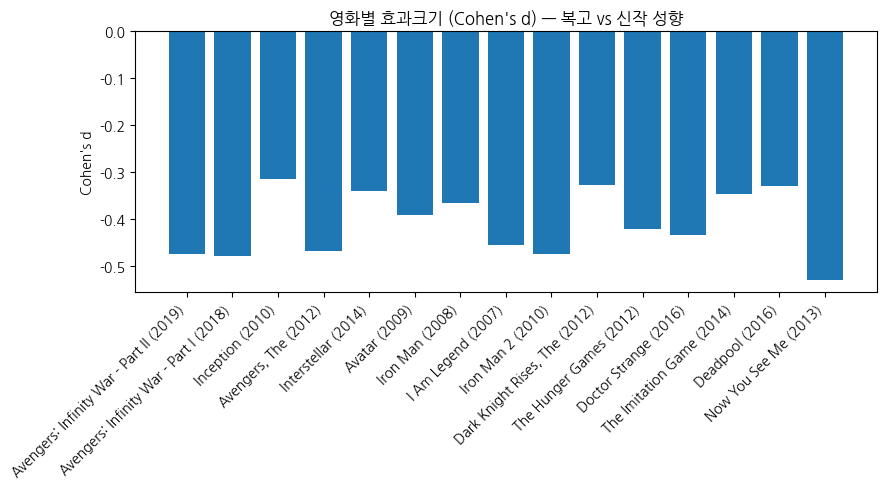

[저장] /mnt/data/movie_group_diff_fdr.csv


In [36]:
# 8) 영화 단위: 복고 vs 신작 그룹 평점차 (Welch + FDR)
age_cut = user_flag[VOCAB["COLS"]["fresh_mean_legacy"]].median()
label = user_flag[[C["user_id"], VOCAB["COLS"]["fresh_mean_legacy"]]].copy()
label["fresh_group"] = np.where(label[VOCAB["COLS"]["fresh_mean_legacy"]] >= age_cut, VOCAB["RETRO_KO"], VOCAB["NEW_KO"])
df_g = df.merge(label[[C["user_id"], "fresh_group"]], on=C["user_id"], how="inner")

rows = []
for mid, g in df_g.groupby(C["movie_id"]):
    a = _clean_numeric(g.loc[g["fresh_group"]==VOCAB["RETRO_KO"], C["rating"]])
    b = _clean_numeric(g.loc[g["fresh_group"]==VOCAB["NEW_KO"],   C["rating"]])
    if len(a) >= CONFIG["MIN_RATINGS_PER_GROUP"] and len(b) >= CONFIG["MIN_RATINGS_PER_GROUP"] and a.var(ddof=1)>0 and b.var(ddof=1)>0:
        t, p = stats.ttest_ind(a, b, equal_var=False)
        d = cohens_d(a, b)
        rows.append((mid, t, p, len(a), len(b), a.mean(), b.mean(), d))

movie_tests = pd.DataFrame(rows, columns=[C["movie_id"],"t","p","n_retro","n_new","mean_retro","mean_new","d"])
if not movie_tests.empty:
    rej, p_adj, _, _ = multipletests(movie_tests["p"].values, method="fdr_bh")
    movie_tests["p_adj_fdr"] = p_adj
    movie_tests["signif"] = rej
    movie_tests = movie_tests.merge(ML_movies_df[[C["movie_id"], C["title"]]], on=C["movie_id"], how="left")

    top = movie_tests.sort_values("p_adj_fdr").head(CONFIG["TOP_K_MOVIES"])
    print("\n[영화별 유의 리스트(FDR 보정) — 상위]")
    print(top[[C["movie_id"], C["title"], "t","p","p_adj_fdr","d","n_retro","n_new","mean_retro","mean_new"]].to_string(index=False))

    plt.figure(figsize=(9,5))
    x = np.arange(len(top))
    plt.bar(x, top["d"].values)
    xt = top[C["title"]].fillna(top[C["movie_id"]]).astype(str)
    plt.xticks(x, xt, rotation=45, ha="right")
    plt.title("영화별 효과크기 (Cohen's d) — 복고 vs 신작 성향")
    plt.ylabel("Cohen's d"); plt.tight_layout(); plt.show()

    maybe_save(movie_tests.sort_values("p_adj_fdr"), "movie_group_diff_fdr.csv")
else:
    print("[영화 단위 검정] 유효 표본 부족 — MIN_RATINGS_PER_GROUP 조정 고려")


[seg_profile preview]
  activity_quartile genre_quartile  user_count  content_age_mean  rating_mean  \
0            Q1(최단)         Q1(좁음)        2669         16.129365     4.113305   
1            Q1(최단)             Q2        2247         17.168804     4.013084   
2            Q1(최단)             Q3        1735         18.007604     3.866810   
3            Q1(최단)         Q4(다양)         686         18.696813     3.609282   
4                Q2         Q1(좁음)        2154         16.229008     4.095229   
5                Q2             Q2        2253         17.034584     4.015690   
6                Q2             Q3        1688         17.738003     3.858201   
7                Q2         Q4(다양)        1241         18.661610     3.640064   

   mainstream_ratio  rarity_median_idf  
0          0.970202           2.226553  
1          0.980535           1.976674  
2          0.980154           2.183558  
3          0.940351           2.891992  
4          0.964787           2.245934  
5

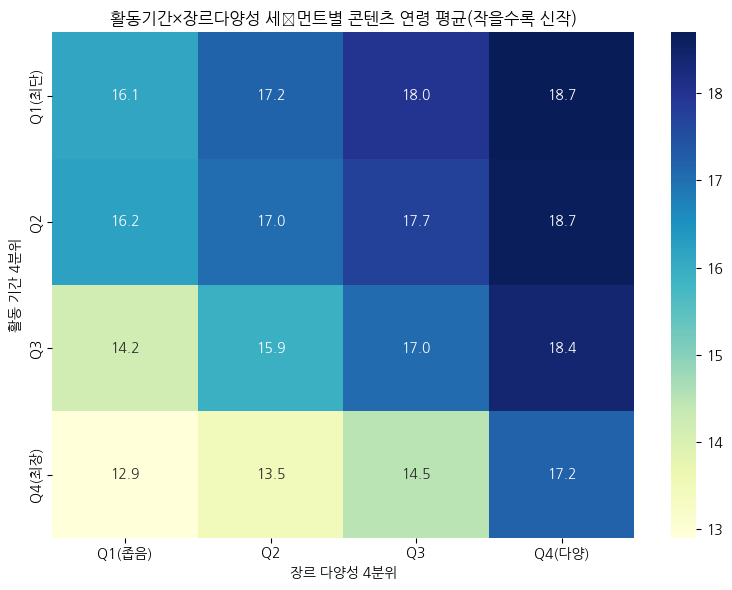

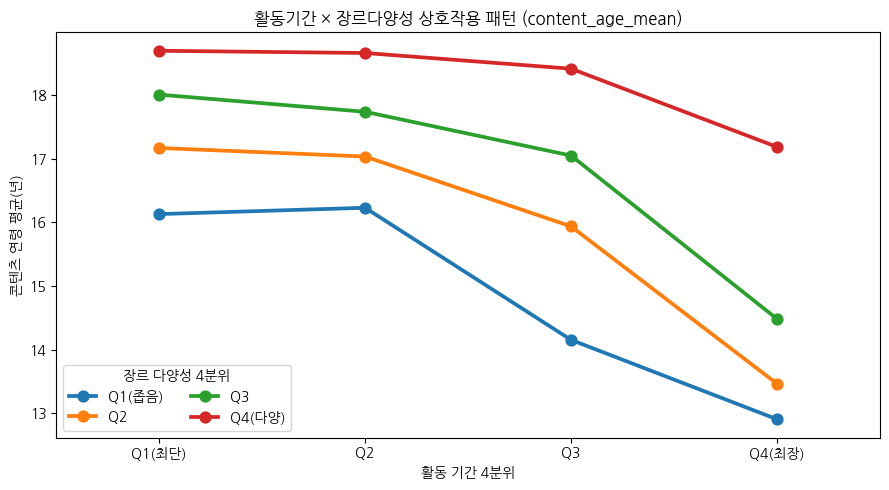

In [37]:
# 9) 활동기간×장르다양성 4분위 세그먼트 + 히트맵/포인트
# 활동기간(일)
rt = ML_ratings_df[[C["user_id"], C["timestamp"]]].copy()
rt["ts"] = pd.to_datetime(rt[C["timestamp"]], unit="s", utc=True)
span = rt.groupby(C["user_id"]).agg(first=("ts","min"), last=("ts","max"))
span[C["tenure_days"]] = (span["last"] - span["first"]).dt.days.clip(lower=0)
span[VOCAB["COLS"]["activity_quartile"]] = q4_by_rank(span[C["tenure_days"]], labels=VOCAB["TENURE_Q_LABELS"])

# 장르 다양성(고유 장르수)
mv = ML_movies_df[[C["movie_id"], C["genres"]]].copy()
rg = ML_ratings_df[[C["user_id"], C["movie_id"]]].drop_duplicates().merge(mv, on=C["movie_id"], how="left")
rg[C["genres"]] = rg[C["genres"]].fillna("(no genres listed)")
rg["__genre_list"] = rg[C["genres"]].str.split("|")
genre_div = rg.explode("__genre_list").groupby(C["user_id"])["__genre_list"].nunique().rename(C["uniq_genres"]).to_frame()
genre_div[VOCAB["COLS"]["genre_quartile"]] = q4_by_rank(genre_div[C["uniq_genres"]], labels=VOCAB["GENRE_Q_LABELS"])

# 결합 + 요약(주요지표 평균)
user_seg4 = (
    span[[C["tenure_days"], VOCAB["COLS"]["activity_quartile"]]]
      .reset_index()
      .merge(genre_div[[C["uniq_genres"], VOCAB["COLS"]["genre_quartile"]]].reset_index(), on=C["user_id"], how="left")
      .set_index(C["user_id"])
)
ux4 = ML_user_features_df.merge(user_seg4, on=C["user_id"], how="left")

seg_profile = (
    ux4.groupby([VOCAB["COLS"]["activity_quartile"], VOCAB["COLS"]["genre_quartile"]])
       .agg(user_count=(C["user_id"],"count"),
            content_age_mean=(VOCAB["COLS"]["fresh_mean_legacy"],"mean"),
            rating_mean=(C["rating_mean"],"mean"),
            mainstream_ratio=(C["mainstream_ratio"],"mean"),
            rarity_median_idf=(C["rarity_median_idf"],"mean"))
       .reset_index()
)
print("\n[seg_profile preview]")
print(seg_profile.head(8))

# 히트맵(콘텐츠 연령 평균)
plt.figure(figsize=(8,6))
pivot = seg_profile.pivot(index=VOCAB["COLS"]["activity_quartile"],
                          columns=VOCAB["COLS"]["genre_quartile"],
                          values="content_age_mean")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("활동기간×장르다양성 세গ먼트별 콘텐츠 연령 평균(작을수록 신작)")
plt.xlabel("장르 다양성 4분위"); plt.ylabel("활동 기간 4분위")
plt.tight_layout(); plt.show()

# 포인트플롯(세그 교차 패턴)
act_order = VOCAB["TENURE_Q_LABELS"]; gen_order = VOCAB["GENRE_Q_LABELS"]
plt.figure(figsize=(9,5))
sns.pointplot(data=seg_profile,
              x=VOCAB["COLS"]["activity_quartile"], y="content_age_mean",
              hue=VOCAB["COLS"]["genre_quartile"], order=act_order, hue_order=gen_order,
              errorbar=("ci",95), markers="o", linestyles="-")
plt.title("활동기간 × 장르다양성 상호작용 패턴 (content_age_mean)")
plt.xlabel("활동 기간 4분위"); plt.ylabel("콘텐츠 연령 평균(년)")
plt.legend(title="장르 다양성 4분위", ncol=2)
plt.tight_layout(); plt.show()

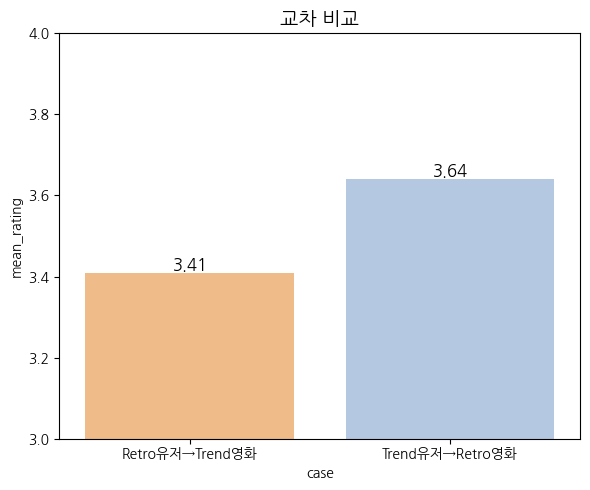

In [38]:
 #10)
# 데이터 (교차 비교용)
df2 = pd.DataFrame({
    "case": ["Retro유저→Trend영화","Trend유저→Retro영화"],
    "mean_rating": [3.41, 3.64]
})

palette_bar = ["#ffbb78", "#aec7e8"]

plt.figure(figsize=(6,5))
ax = sns.barplot(data=df2, x="case", y="mean_rating", palette=palette_bar)
ax.set_title("교차 비교", fontsize=14)
ax.set_ylim(3.0, 4.0)

# 🔑 수치 폰트 크기 조정 (fontsize=12)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

plt.tight_layout()
plt.show()

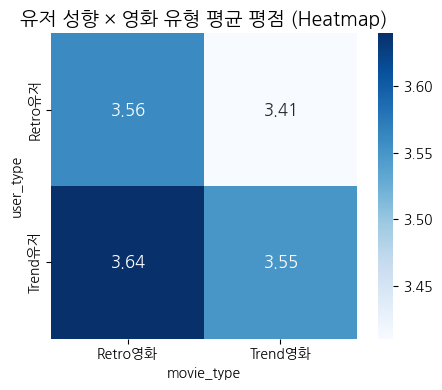

In [39]:
# 11)
# 데이터 (유저 × 영화 교차표용)
df1 = pd.DataFrame({
    "user_type": ["Retro유저","Retro유저","Trend유저","Trend유저"],
    "movie_type": ["Retro영화","Trend영화","Retro영화","Trend영화"],
    "mean_rating": [3.56, 3.41, 3.64, 3.55]
})

# pivot에서 실제 컬럼명 사용
pivot_df = df1.pivot(index="user_type", columns="movie_type", values="mean_rating")

plt.figure(figsize=(5,4))
sns.heatmap(
    pivot_df, annot=True, fmt=".2f", cmap="Blues",
    cbar=True, square=True,
    annot_kws={"fontsize":12, "fontweight":"bold"}  # 🔑 수치 폰트 키우기
)
plt.title("유저 성향 × 영화 유형 평균 평점 (Heatmap)", fontsize=14)
plt.tight_layout()
plt.show()